In [2]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os


In [3]:
# Pointer to the data locations

ROOT = "data_pipeline/dataset"

class DataConfig():
    def __init__(self, root):
        self.train_dir = f"{root}/train"
        self.test_dir = f"{root}/test"

    def num_train_objects(self):
        return len(os.listdir(self.train_dir))
    
    def num_test_objects(self):
        return len(os.listdir(self.test_dir))
    
    def train_test_ratio(self):
        return self.num_train_objects()/self.num_test_objects()
    
data_cfg = DataConfig(ROOT)
folder_dataset = datasets.ImageFolder(root=data_cfg.train_dir)


In [4]:
# Create map from image class to images. Helps with choosing pairs later on
from collections import defaultdict

class_image_lookup = defaultdict(list)
for pair in folder_dataset.imgs:
    image_path, image_class = pair
    class_image_lookup[image_class].append(image_path)
    
print(random.choice(class_image_lookup[100]))

data_pipeline/dataset/train/0400011938069/0400011938069_A2.jpg


In [5]:
# Implement torch data loader

class SiameseNetworkDataset(Dataset):
    
    def __init__(self, image_folder_dataset, transform=None, should_invert=True):
        self.image_folder_dataset = image_folder_dataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        # Pick a random image from the dataset
        first_image, first_image_class = random.choice(self.image_folder_dataset.imgs)
        
        # Randomly roll to get the same class
        should_get_same_class = random.randint(0,1) 
        
        # In the event that we should pick the same class, pick a random sample from the same image
        # class (that's not the same image)
        if should_get_same_class:
            second_image_class = first_image_class
            second_image = random.choice(class_image_lookup[first_image_class])
            
        # Otherwise, pick something from a different image class. Ok to randomly choose from the whole dataset
        # here (low probability of collision)
        else:
            while True:
                second_image, second_image_class = random.choice(self.image_folder_dataset.imgs) 
                if first_image_class != second_image_class:
                    break

        # Process images
        first_image = Image.open(first_image)
        first_image = first_image.convert("L")
        second_image = Image.open(second_image)
        second_image = second_image.convert("L")
        
        # Maybe invert
        if self.should_invert:
            first_image = PIL.ImageOps.invert(first_image)
            second_image = PIL.ImageOps.invert(second_image)

        if self.transform is not None:
            first_image = self.transform(first_image)
            second_image = self.transform(second_image)
        
        return first_image, second_image, torch.from_numpy(np.array([int(first_image_class != second_image_class)], dtype=np.float32))
    
    def __len__(self):
        return len(self.image_folder_dataset.imgs)
    
# Build dataset
siamese_dataset = SiameseNetworkDataset(image_folder_dataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

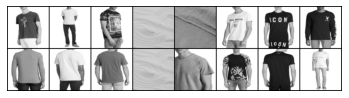

[[1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [6]:
# Util to show images
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Visualize some data
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

# Examine what contrastinc and different batches look like
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [11]:
# Define the network. Standard siamese from paper
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # First CNN
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),          
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
# Contrastive loss
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [13]:
# Check out the network
print(SiameseNetwork())

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)


In [9]:
# Set the loss function
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

# Containers for metrics
counter = []
loss_history = [] 
iteration_number= 0

# Set batch size and epocs
batch_size = 64
epochs = 100

# Train! Load the data
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=batch_size)

# Run training
for epoch in range(0, epochs):
    for i, data in enumerate(train_dataloader, 0):
        # Get images and labels
        first_image, second_image, label = data
        
        # Set the context to cuda
        first_image, second_image, label = first_image.cuda(), second_image.cuda(), label.cuda()
        
        # Zero out gradients
        optimizer.zero_grad()
        
        # Get output for the two images
        output1, output2 = net(first_image, second_image)
        
        # Compute contrastive loss.
        loss_contrastive = criterion(output1, output2, label)
        
        # Propogate loss backwards
        loss_contrastive.backward()
        
        # Conclude the step
        optimizer.step()
        
        # Log the current loss every 10 steps
        if i %10 == 0:
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
            
# Plot the training history
show_plot(counter,loss_history)

Epoch number 0
 Current loss 1.839180588722229

Epoch number 0
 Current loss 8.307300567626953

Epoch number 0
 Current loss 2.0406737327575684

Epoch number 0
 Current loss 1.8746891021728516

Epoch number 0
 Current loss 0.7836811542510986

Epoch number 1
 Current loss 0.7466226816177368

Epoch number 1
 Current loss 1.4478602409362793

Epoch number 1
 Current loss 1.4309968948364258

Epoch number 1
 Current loss 0.7742263078689575

Epoch number 1
 Current loss 0.4976707100868225

Epoch number 2
 Current loss 1.1540436744689941

Epoch number 2
 Current loss 1.036961317062378

Epoch number 2
 Current loss 0.6656999588012695

Epoch number 2
 Current loss 0.7247934341430664

Epoch number 2
 Current loss 1.8107967376708984

Epoch number 3
 Current loss 0.7033896446228027

Epoch number 3
 Current loss 0.5656328201293945

Epoch number 3
 Current loss 1.1444823741912842

Epoch number 3
 Current loss 0.7248607277870178

Epoch number 3
 Current loss 0.42440715432167053

Epoch number 4
 Curren

KeyboardInterrupt: 